In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import datasets
import matplotlib.pyplot as plt

In [37]:
variances = [0.001,1,2,5,10,20,50,100]
ttt = []
resnet18 = []
# Load the models
model1 = ResNet(26, 1, channels=3, classes=10, norm_layer=nn.BatchNorm2d)
checkpoint = torch.load('ckpt.pth')
model1.load_state_dict(checkpoint['net'])

model2 = torchvision.models.resnet18(pretrained=False)
model2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model2.fc = nn.Linear(512, 10)
model2.load_state_dict(torch.load('mnist.pth'))

# Set the models to evaluation mode
model1.eval()
model2.eval()

for i in variances:
    # Define the data transformation
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.GaussianBlur(kernel_size=3, sigma=(i,i)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # Load the MNIST test dataset
    test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

    # Define the data loader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Define the loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Initialize counters for correct predictions
    correct1 = 0
    correct2 = 0

    # Loop over the test dataset
    for data, target in test_loader:

        # Forward pass through model 1
        output1 = model1(data)
        # Calculate the loss for model 1
        loss1 = criterion(output1, target)
        # Calculate the number of correct predictions for model 1
        pred1 = output1.argmax(dim=1, keepdim=True)
        correct1 += pred1.eq(target.view_as(pred1)).sum().item()

        # Forward pass through model 2
        output2 = model2(data)
        # Calculate the loss for model 2
        loss2 = criterion(output2, target)
        # Calculate the number of correct predictions for model 2
        pred2 = output2.argmax(dim=1, keepdim=True)
        correct2 += pred2.eq(target.view_as(pred2)).sum().item()

    # Calculate and print the accuracy for each model
    accuracy1 = correct1 / len(test_loader.dataset)
    accuracy2 = correct2 / len(test_loader.dataset)
    ttt.append(accuracy1)
    resnet18.append(accuracy2)
    print(f'Model 1 accuracy: {accuracy1}')
    print(f'Model 2 accuracy: {accuracy2}')

Model 1 accuracy: 0.9937
Model 2 accuracy: 0.7072
Model 1 accuracy: 0.9919
Model 2 accuracy: 0.5581
Model 1 accuracy: 0.9906
Model 2 accuracy: 0.5287
Model 1 accuracy: 0.9903
Model 2 accuracy: 0.5226
Model 1 accuracy: 0.9901
Model 2 accuracy: 0.5218
Model 1 accuracy: 0.9902
Model 2 accuracy: 0.5211
Model 1 accuracy: 0.9902
Model 2 accuracy: 0.5211
Model 1 accuracy: 0.9902
Model 2 accuracy: 0.5211


Text(0.5, 1.0, 'TTT vs ResNet18 Accuracy on MNIST across different AWGN variances')

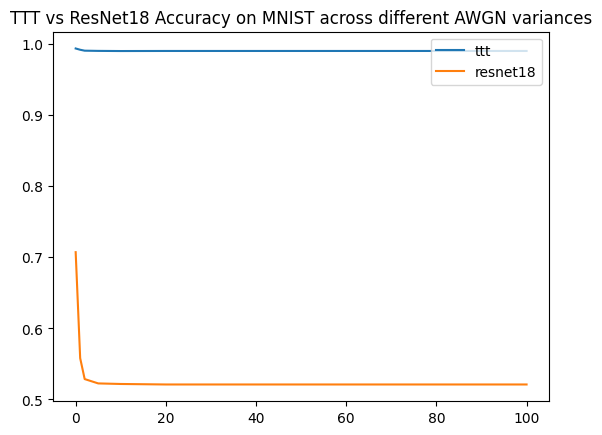

In [47]:
fig, arr = plt.subplots((1))
arr.plot(variances,ttt, label='ttt')
arr.plot(variances,resnet18, label='resnet18')
arr.legend(loc='upper right')
arr.set_title('TTT vs ResNet18 Accuracy on MNIST across different AWGN variances')

In [63]:
def add_noise(images, noise_level=0.05):
    noisy_images = images.clone()  # Make a copy of the input tensor
    for image in noisy_images:
        # Generate a mask of random pixels to add noise to
        mask = torch.rand_like(image) < noise_level
        
        # Set random pixels to either 0 (salt) or 1 (pepper)
        salt_mask = mask & (torch.rand_like(image) < 0.5)
        pepper_mask = mask & (torch.rand_like(image) >= 0.5)
        image[salt_mask] = 1.0
        image[pepper_mask] = 0.0
        
    return noisy_images

In [65]:
# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load the MNIST test dataset
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Create a new dataset with salt and pepper noise added to the images
noisy_trainset = [(add_noise(images), labels) for images, labels in test_dataset]

# Create a dataloader for the noisy dataset
test_loader = torch.utils.data.DataLoader(noisy_trainset, batch_size=64, shuffle=True)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Initialize counters for correct predictions
correct1 = 0
correct2 = 0

# Loop over the test dataset
for data, target in test_loader:

    # Forward pass through model 1
    output1 = model1(data)
    # Calculate the loss for model 1
    loss1 = criterion(output1, target)
    # Calculate the number of correct predictions for model 1
    pred1 = output1.argmax(dim=1, keepdim=True)
    correct1 += pred1.eq(target.view_as(pred1)).sum().item()

    # Forward pass through model 2
    output2 = model2(data)
    # Calculate the loss for model 2
    loss2 = criterion(output2, target)
    # Calculate the number of correct predictions for model 2
    pred2 = output2.argmax(dim=1, keepdim=True)
    correct2 += pred2.eq(target.view_as(pred2)).sum().item()

# Calculate and print the accuracy for each model
accuracy1 = correct1 / len(test_loader.dataset)
accuracy2 = correct2 / len(test_loader.dataset)
ttt.append(accuracy1)
resnet18.append(accuracy2)
print(f'Model 1 accuracy: {accuracy1}')
print(f'Model 2 accuracy: {accuracy2}')

Model 1 accuracy: 0.9893
Model 2 accuracy: 0.6806


Text(0.5, 1.0, 'TTT vs ResNet18 Accuracy on MNIST with Salt and Pepper Noise')

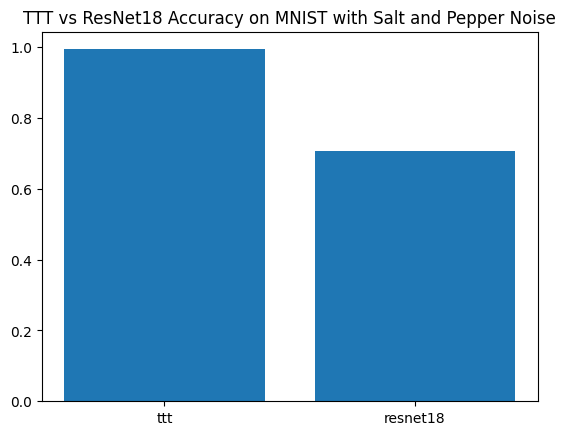

In [66]:
fig, arr = plt.subplots((1))
arr.bar(['ttt','resnet18'],[ttt[0], resnet18[0]])
arr.set_title('TTT vs ResNet18 Accuracy on MNIST with Salt and Pepper Noise')

In [70]:
variances = [0.001,0.01,0.1,1,2,5,10]
ttt = []
resnet18 = []
def add_gaussian_noise(img, mean=0, std=0.1):
    noise = torch.randn(img.size()) * std + mean
    noisy_img = img + noise
    return noisy_img

for i in variances:
    # Define the data transformation
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # Load the MNIST test dataset
    test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
    test_dataset = [(add_gaussian_noise(images, mean=0, std=i), labels) for images, labels in test_dataset]
    # Define the data loader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Define the loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Initialize counters for correct predictions
    correct1 = 0
    correct2 = 0

    # Loop over the test dataset
    for data, target in test_loader:

        # Forward pass through model 1
        output1 = model1(data)
        # Calculate the loss for model 1
        loss1 = criterion(output1, target)
        # Calculate the number of correct predictions for model 1
        pred1 = output1.argmax(dim=1, keepdim=True)
        correct1 += pred1.eq(target.view_as(pred1)).sum().item()

        # Forward pass through model 2
        output2 = model2(data)
        # Calculate the loss for model 2
        loss2 = criterion(output2, target)
        # Calculate the number of correct predictions for model 2
        pred2 = output2.argmax(dim=1, keepdim=True)
        correct2 += pred2.eq(target.view_as(pred2)).sum().item()

    # Calculate and print the accuracy for each model
    accuracy1 = correct1 / len(test_loader.dataset)
    accuracy2 = correct2 / len(test_loader.dataset)
    ttt.append(accuracy1)
    resnet18.append(accuracy2)
    print(f'Model 1 accuracy: {accuracy1}')
    print(f'Model 2 accuracy: {accuracy2}')

Model 1 accuracy: 0.9937
Model 2 accuracy: 0.707
Model 1 accuracy: 0.9937
Model 2 accuracy: 0.7062
Model 1 accuracy: 0.9929
Model 2 accuracy: 0.6984
Model 1 accuracy: 0.1251
Model 2 accuracy: 0.3429
Model 1 accuracy: 0.1035
Model 2 accuracy: 0.1426
Model 1 accuracy: 0.1028
Model 2 accuracy: 0.1079
Model 1 accuracy: 0.1012
Model 2 accuracy: 0.1031


Text(0.5, 1.0, 'TTT vs ResNet18 Accuracy on MNIST across different AWGN variances')

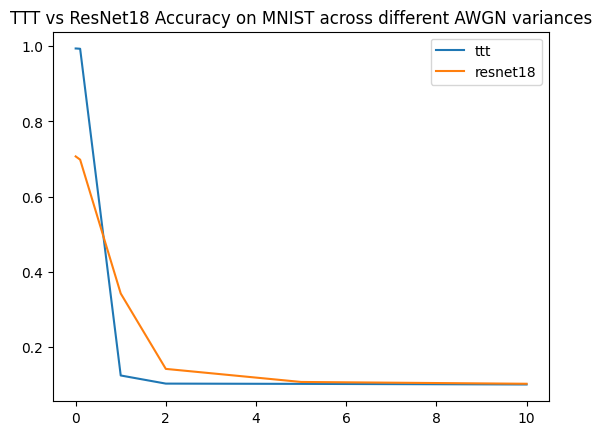

In [72]:
fig, arr = plt.subplots((1))
arr.plot(variances,ttt, label='ttt')
arr.plot(variances,resnet18, label='resnet18')
arr.legend(loc='upper right')
arr.set_title('TTT vs ResNet18 Accuracy on MNIST across different AWGN variances')